In [1]:
# loading imports

import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import re

import random
import os

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\viswa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# project directory

base_path = Path(".")         
data_path = base_path / "data"  
results_path = base_path / "results" / "ff" 

In [3]:
# loading the cleaned dataset

clean_path = data_path / "cases_clean.csv"
df = pd.read_csv(clean_path, encoding="utf-8")
df.head()

,case_name,year,first_party,second_party,text,label
0,"Time, Inc. v. Pape",1970,"Time, Inc.",Frank Pape,"In November 1961, the Civil Rights Commission ...",1
1,Griggs v. Duke Power Company,1970,Griggs,Duke Power Company,"Willie Griggs filed a class action, on behalf ...",1
2,United States v. White,1970,United States,James A. White,"A government informant, Harvey Jackson, wore a...",1
3,North Carolina v. Alford,1970,North Carolina,Henry C. Alford,North Carolina charged Henry Alford with first...,1
4,Griffin v. Breckenridge,1970,Eugene Griffin et al.,Lavon Breckenridge et al.,A group of black Mississippi citizens filed fo...,1


In [4]:
# tokenization and vocab

from collections import Counter
stop_words = set(stopwords.words('english'))

def tokenize(text):
    text = text.lower()
    tokens = re.findall(r"[a-zA-Z]+", text)
    return tokens
tokenized_docs = df["text"].apply(tokenize)

word_counts = Counter()
for tokens in tokenized_docs:
    word_counts.update(tokens)

valid_words = {w for w, c in word_counts.items() if c > 1 and w not in stop_words}
tokenized_docs = tokenized_docs.apply(lambda toks: [t for t in toks if t in valid_words])

word_counts = Counter()
for tokens in tokenized_docs:
    word_counts.update(tokens)

max_vocab = 45000
most_common = word_counts.most_common(max_vocab - 2)

word2idx = {"<PAD>": 0,"<UNK>": 1}
for i, (word, count) in enumerate(most_common, start=2):
    word2idx[word] = i
vocab_size = len(word2idx)
vocab_size

44674

In [5]:
# function to convert tokens to index sequences

def tokens_to_indices(tokens, word2idx):
    indices = []
    for tok in tokens:
        if tok in word2idx:
            indices.append(word2idx[tok])
        else:
            indices.append(word2idx["<UNK>"])
    return indices
indexed_docs = tokenized_docs.apply(lambda toks: tokens_to_indices(toks, word2idx))

print(indexed_docs.iloc[0][:50])

[3026, 322, 130, 296, 1875, 535, 3084, 495, 203, 8, 71, 1541, 159, 13784, 53, 767, 198, 2, 5, 5561, 137, 8043, 5, 151, 1484, 3875, 8043, 376, 5072, 5561, 2737, 9056, 31169, 424, 14, 5561, 159, 1781, 166, 1152, 1148, 122, 853, 2893, 770, 130, 1561, 495, 1875, 28]


In [6]:
# Sequence Padding

max_len = 45000
def pad_or_truncate(indices, max_len = max_len):
    if len(indices) < max_len:
        return indices + [0] * (max_len - len(indices))
    else:
        return indices[:max_len]

padded_docs = indexed_docs.apply(pad_or_truncate)
X = np.array(padded_docs.tolist(), dtype=np.int32)
X.shape

(2679, 45000)

In [7]:
# preparing the labels

y = df["label"].values.astype(np.int64)
np.bincount(y)

array([ 968, 1711])

In [8]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train.shape, X_test.shape

((2143, 45000), (536, 45000))

In [9]:
# Balanced Training set

# find indices for each class in the training split
pos_idx = np.where(y_train == 1)[0]
neg_idx = np.where(y_train == 0)[0]

print("Training positives:", len(pos_idx))
print("Training negatives:", len(neg_idx))

n_min = min(len(pos_idx), len(neg_idx))
print("Balancing to:", n_min, "per class")

np.random.seed(SEED)
pos_sample = np.random.choice(pos_idx, n_min, replace=False)
neg_sample = np.random.choice(neg_idx, n_min, replace=False)

balanced_idx = np.concatenate([pos_sample, neg_sample])
np.random.shuffle(balanced_idx)

X_train_bal = X_train[balanced_idx]
y_train_bal = y_train[balanced_idx]

print("Balanced X_train shape:", X_train_bal.shape)
print("Balanced label counts:", np.bincount(y_train_bal))

Training positives: 1369
Training negatives: 774
Balancing to: 774 per class
Balanced X_train shape: (1548, 45000)
Balanced label counts: [774 774]


In [10]:
# data wrapper

class SCOTUSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype = torch.long)
        self.y = torch.tensor(y, dtype = torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SCOTUSDataset(X_train_bal, y_train_bal)
test_dataset = SCOTUSDataset(X_test, y_test)

In [11]:
# batching data loader

batch = 8
g = torch.Generator()
g.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size = batch, shuffle  =True, generator = g)
test_loader = DataLoader(test_dataset, batch_size = batch, shuffle = False, generator = g)

In [12]:
# feedforward embedding model

class FeedForwardEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, emb_dim = 100, hidden_dim = 128):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings = vocab_size,
            embedding_dim = emb_dim,
            padding_idx = 0
        )

        self.fc1 = nn.Linear(emb_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = embedded.mean(dim = 1)
        h = self.relu(self.fc1(pooled))
        out = self.sigmoid(self.fc2(h))
        return out.squeeze()

In [13]:
# initliazing model, loss and optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FeedForwardEmbeddingModel(vocab_size = vocab_size, emb_dim = 100, hidden_dim = 128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [14]:
# training fucntion

loss_history = []
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss = {avg_loss:.4f}")

In [15]:
# evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            preds = (outputs >= 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return acc, prec, rec, f1

In [16]:
EPOCHS = 10
train_model(model, train_loader, criterion, optimizer, device, epochs=EPOCHS)

Epoch 1/10, Loss = 0.6935
Epoch 2/10, Loss = 0.6932
Epoch 3/10, Loss = 0.6902
Epoch 4/10, Loss = 0.6740
Epoch 5/10, Loss = 0.6177
Epoch 6/10, Loss = 0.5126
Epoch 7/10, Loss = 0.3856
Epoch 8/10, Loss = 0.2751
Epoch 9/10, Loss = 0.1844
Epoch 10/10, Loss = 0.1219


In [17]:
acc, prec, rec, f1 = evaluate_model(model, test_loader, device)

Accuracy:  0.5410
Precision: 0.6920
Recall:    0.5058
F1 Score:  0.5845


In [18]:
# helper to save plots

def save_plot(fig, name, dpi=300):
    name = name if name.endswith(".png") else f"{name}.png"
    fig.savefig(results_path / name, dpi=dpi, bbox_inches='tight')

In [19]:
# helper to save tables

def save_table(df, name):
    name = name if name.endswith(".csv") else f"{name}.csv"
    df.to_csv(results_path / name, index=False, encoding="utf-8")

In [20]:
results_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [acc, prec, rec, f1]
})

display(results_df)
save_table(results_df, "performance_table_clean_balanced")

,Metric,Value
0,Accuracy,0.541045
1,Precision,0.692000
2,Recall,0.505848
3,F1 Score,0.584459


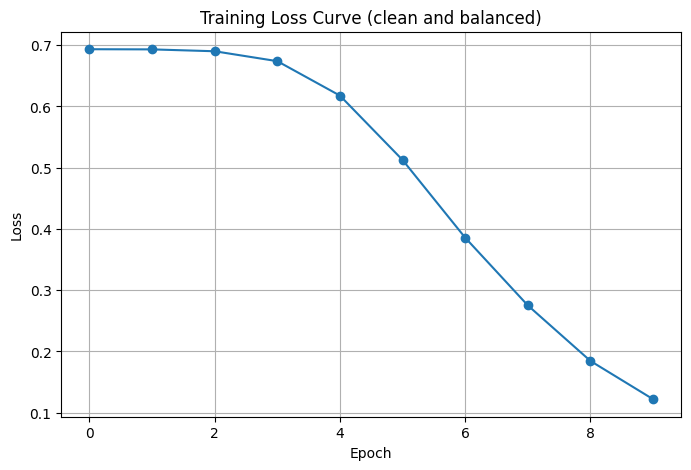

In [47]:
# training loss curve

fig = plt.figure(figsize=(8,5))
plt.plot(loss_history, marker='o')
plt.title("Training Loss Curve (clean and balanced)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
save_plot(fig, "loss_curve_balanced")
plt.show()

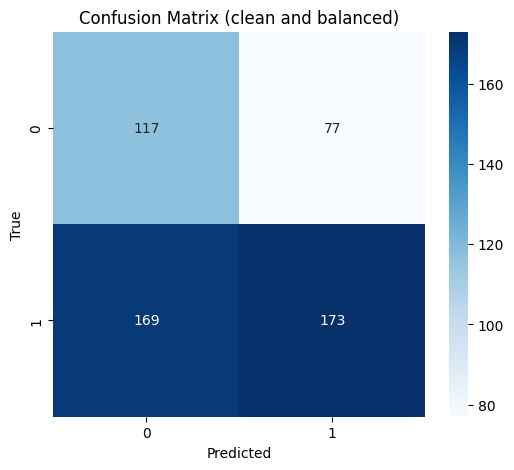

In [48]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_conf_matrix(model, loader, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            batch_preds = (outputs >= 0.5).float()
            preds.extend(batch_preds.cpu().numpy())
            labels.extend(y.numpy())
    cm = confusion_matrix(labels, preds)

    fig = plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix (clean and balanced)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    save_plot(fig, "confusion_matrix_balanced")  
    plt.show()
plot_conf_matrix(model, test_loader, device)

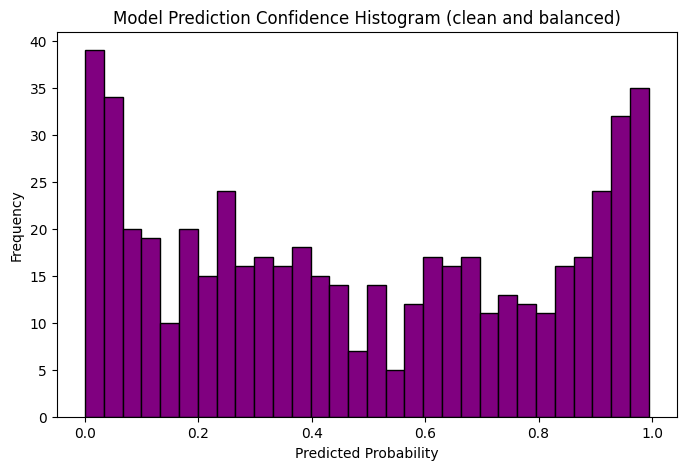

In [49]:
# prediction confidence histogram

model.eval()
confidences = []

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        outputs = model(x)
        confidences.extend(outputs.cpu().numpy())
fig = plt.figure(figsize=(8,5))
plt.hist(confidences, bins=30, color='purple', edgecolor='black')
plt.title("Model Prediction Confidence Histogram (clean and balanced)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
save_plot(fig, "confidence_histogram_clean_balanced")
plt.show()

In [25]:
# error collection

errors = []
correct = []

model.eval()
with torch.no_grad():
    for idx, (x, y) in enumerate(test_loader):
        x = x.to(device)
        outputs = model(x)
        preds = (outputs >= 0.5).float().cpu().numpy()
        ys = y.numpy()

        for i in range(len(preds)):
            seq = test_dataset.X[idx*batch + i].numpy()
            if preds[i] == ys[i]:
                correct.append((preds[i], ys[i], seq))
            else:
                errors.append((preds[i], ys[i], seq))


def indices_to_text(indices, idx2word):
    words = []
    for idx in indices:
        if idx == 0:
            continue
        words.append(idx2word.get(idx, "<UNK>"))
    return " ".join(words)

idx2word = {v: k for k, v in word2idx.items()}

for i in range(5):
    pred, true, seq = errors[i]
    text = indices_to_text(seq, idx2word)

    print(f"TRUE LABEL: {true}, PREDICTED: {pred}")
    print(text)

TRUE LABEL: 1.0, PREDICTED: 0.0
tax injunction act establishes general rule federal courts interfere matters state taxation railroad revitalization regulatory reform act r act provides exception railroads effort prevent state tax discrimination railroads section r act requires ratio assessed value true market value railroad property exceed five percent ratio assessed value true market value commercial industrial property assessment jurisdiction calculation requires states determine true market value railroads property valuation subjective using new valuation methodology georgia state board equalization appraised property railroad company csx transportation inc billion csx filed complaint r act noting old appraisal methodology would valued property billion despite csx argument r act allows railroads challenge state valuation methods district court ruled state methodology could considered u eleventh circuit ruled absence clear statement r act principles federalism weighed interpreting ac

In [26]:
error_texts = []

for pred, true, seq in errors:
    txt = indices_to_text(seq, idx2word)
    error_texts.append({"pred": pred, "true": true, "text": txt})


In [27]:
df_errors = pd.DataFrame(error_texts)
df_errors.head()

,pred,true,text
0,0.0,1.0,tax injunction act establishes general rule fe...
1,0.0,1.0,piccadilly cafeterias filed chapter bankruptcy...
2,0.0,1.0,balsys subpoenaed justice department office sp...
3,0.0,1.0,john booth murders elderly couple chose jury d...
4,1.0,0.0,local police little rock arkansas received tip...


In [28]:
error_matrix = pd.crosstab(df_errors["true"], df_errors["pred"])
print(error_matrix)

pred  0.0  1.0
true          
0.0     0   77
1.0   169    0


In [29]:
# Categorizing text by usage of different words
negation_words = [" not ", " no ", " without ", " unless ", " except "]
proc_words = ["jurisdiction", "remand", "procedural", "motion", "rule", "appeal", "appellate", "standard"]
statute_words = ["section", "statute", "usc", "act", "§", "subsection", "clause"]

# Comparing average
def count_matches(text, words):
    text_lower = text.lower()
    return sum(text_lower.count(w) for w in words)

df_errors["negation_count"] = df_errors["text"].apply(lambda t: count_matches(t, negation_words))
df_errors["procedural_count"] = df_errors["text"].apply(lambda t: count_matches(t, proc_words))
df_errors["statute_count"] = df_errors["text"].apply(lambda t: count_matches(t, statute_words))

In [30]:
correct_texts = []
for pred, true, seq in correct:
    txt = indices_to_text(seq, idx2word)
    correct_texts.append({"pred": pred, "true": true, "text": txt})

df_correct = pd.DataFrame(correct_texts)

df_correct["negation_count"] = df_correct["text"].apply(lambda t: count_matches(t, negation_words))
df_correct["procedural_count"] = df_correct["text"].apply(lambda t: count_matches(t, proc_words))
df_correct["statute_count"] = df_correct["text"].apply(lambda t: count_matches(t, statute_words))

In [31]:
comparison = pd.DataFrame({
    "Feature": ["Negation words", "Procedural words", "Statute/citation words"],
    "Avg Incorrect": [
        df_errors["negation_count"].mean(),
        df_errors["procedural_count"].mean(),
        df_errors["statute_count"].mean(),
    ],
    "Avg Correct": [
        df_correct["negation_count"].mean(),
        df_correct["procedural_count"].mean(),
        df_correct["statute_count"].mean(),
    ]
})

comparison
save_table(comparison, "balanced_word_category_correct_incorrect")

In [32]:
false_pos = []
false_neg = []

for pred, true, seq in errors:
    if pred == 1.0 and true == 0.0:
        false_pos.append(seq)   # predicted guilty incorrectly
    elif pred == 0.0 and true == 1.0:
        false_neg.append(seq)   # predicted not guilty incorrectly

In [33]:
df_fp = pd.DataFrame([indices_to_text(seq, idx2word) for seq in false_pos], columns=["text"])
df_fn = pd.DataFrame([indices_to_text(seq, idx2word) for seq in false_neg], columns=["text"])

In [34]:
def count_matches(text, keywords):
    t = text.lower()
    return sum(t.count(k) for k in keywords)

df_fp["negations"] = df_fp["text"].apply(lambda t: count_matches(t, negation_words))
df_fn["negations"] = df_fn["text"].apply(lambda t: count_matches(t, negation_words))

df_fp["procedural_terms"] = df_fp["text"].apply(lambda t: count_matches(t, proc_words))
df_fn["procedural_terms"] = df_fn["text"].apply(lambda t: count_matches(t, proc_words))

df_fp["statute_terms"] = df_fp["text"].apply(lambda t: count_matches(t, statute_words))
df_fn["statute_terms"] = df_fn["text"].apply(lambda t: count_matches(t, statute_words))

In [35]:
comparison = pd.DataFrame({
    "Feature": ["Negation", "Procedural", "Statutory"],
    "False Positives (avg)": [
        df_fp["negations"].mean(),
        df_fp["procedural_terms"].mean(),
        df_fp["statute_terms"].mean()
    ],
    "False Negatives (avg)": [
        df_fn["negations"].mean(),
        df_fn["procedural_terms"].mean(),
        df_fn["statute_terms"].mean()
    ]
})

print(comparison)
save_table(comparison, "balanced_word_category_errors")

      Feature  False Positives (avg)  False Negatives (avg)
0    Negation               9.467532               9.668639
1  Procedural              44.415584              37.011834
2   Statutory             107.766234             123.112426


In [36]:
def true_length(seq):
    # assuming 0 is <PAD>
    return int((seq != 0).sum())

# Comparing average length of text between correct and incorrect
false_pos_seqs = [seq for pred, true, seq in errors if pred == 1.0 and true == 0.0]
false_neg_seqs = [seq for pred, true, seq in errors if pred == 0.0 and true == 1.0]

fp_lengths = [true_length(seq) for seq in false_pos_seqs]
fn_lengths = [true_length(seq) for seq in false_neg_seqs]
correct_lengths = [true_length(seq) for _, _, seq in correct]

print(f"Correctly classified: {np.mean(correct_lengths):.2f} tokens")
print(f"False Positives:      {np.mean(fp_lengths):.2f} tokens")
print(f"False Negatives:      {np.mean(fn_lengths):.2f} tokens")

Correctly classified: 4434.04 tokens
False Positives:      4460.09 tokens
False Negatives:      4569.02 tokens


In [37]:
from collections import Counter

# word_frequency over indices (your current code)
all_words = []
for seq in indexed_docs:   # each seq is a list of ints
    all_words.extend(seq)

word_frequency = Counter(all_words)

rare_threshold = 200
# Here, `idx` is already an integer token id
rare_word_indices = {idx for idx, count in word_frequency.items() if count < rare_threshold}

def count_rare_tokens(seq):
    return sum(1 for token in seq if token in rare_word_indices and token != 0)

correct_rare   = [count_rare_tokens(seq) for _, _, seq in correct]
incorrect_rare = [count_rare_tokens(seq) for _, _, seq in errors]
fp_rare        = [count_rare_tokens(seq) for pred, true, seq in errors if pred == 1.0 and true == 0.0]
fn_rare        = [count_rare_tokens(seq) for pred, true, seq in errors if pred == 0.0 and true == 1.0]

print("Rare-word index count:", len(rare_word_indices))
print("Correct Predictions: ", np.mean(correct_rare))
print("Misclassified:       ", np.mean(incorrect_rare))
print("False Positives:     ", np.mean(fp_rare))
print("False Negatives:     ", np.mean(fn_rare))

Rare-word index count: 39285
Correct Predictions:  334.9344827586207
Misclassified:        362.6788617886179
False Positives:      342.3376623376623
False Negatives:      371.94674556213016


In [38]:
# separate sequences for errors and correct predictions
error_seqs = [seq for _, _, seq in errors]
correct_seqs = [seq for _, _, seq in correct]

error_rare_counts_idx = Counter()
correct_rare_counts_idx = Counter()

for seq in error_seqs:
    for tok in seq:
        if tok != 0 and tok in rare_word_indices:
            error_rare_counts_idx[tok] += 1

for seq in correct_seqs:
    for tok in seq:
        if tok != 0 and tok in rare_word_indices:
            correct_rare_counts_idx[tok] += 1

len(error_rare_counts_idx), len(correct_rare_counts_idx)

(16817, 17481)

In [39]:
error_rare_counts_idx   = Counter()
correct_rare_counts_idx = Counter()
fp_rare_counts_idx      = Counter()
fn_rare_counts_idx      = Counter()

# Count per misclassified case
for pred, true, seq in errors:
    rare_in_seq = set(seq) & rare_word_indices  # unique rare tokens in that case
    for tok_idx in rare_in_seq:
        error_rare_counts_idx[tok_idx] += 1
        if pred == 1.0 and true == 0.0:
            fp_rare_counts_idx[tok_idx] += 1
        elif pred == 0.0 and true == 1.0:
            fn_rare_counts_idx[tok_idx] += 1

# Count per correctly classified case
for pred, true, seq in correct:
    rare_in_seq = set(seq) & rare_word_indices
    for tok_idx in rare_in_seq:
        correct_rare_counts_idx[tok_idx] += 1

# summary table
rows = []
for tok_idx, err_ct in error_rare_counts_idx.items():
    corr_ct = correct_rare_counts_idx.get(tok_idx, 0)
    fp_ct   = fp_rare_counts_idx.get(tok_idx, 0)
    fn_ct   = fn_rare_counts_idx.get(tok_idx, 0)

    total_cases = err_ct + corr_ct
    min_threshold = max(10, int(0.05 * len(errors)))  # 5% of total misclassified cases
    if total_cases >= min_threshold:
        word = idx2word.get(tok_idx, "<UNK>")
        rows.append((word, tok_idx, err_ct, corr_ct, fp_ct, fn_ct,
                     total_cases, err_ct / total_cases))

comparison = pd.DataFrame(
    rows,
    columns=[
        "word", "token_idx", "error_count", "correct_count",
        "false_positive", "false_negative", "total_cases", "error_ratio"
    ]
).sort_values("error_ratio", ascending=False)

top5 = comparison.head(5)

save_table(top5, "balanced_rare_word_usage")

top5

,word,token_idx,error_count,correct_count,false_positive,false_negative,total_cases,error_ratio
954,popular,5686,14,2,2,12,16,0.875000
653,ninety,6892,12,2,3,9,14,0.857143
425,particulars,7710,12,2,3,9,14,0.857143
717,taft,7555,11,2,4,7,13,0.846154
1003,giant,11240,10,2,3,7,12,0.833333
